**Практическая работа #2. Машинное обучение в задачах обнаружения спама и мошеннических действий.**

Работу выполнил студент:

группы: ББМО-01-23

Белов Владимир Станиславович

**Задание 1. Наивный Байесовский классификатор.**

Подключим библиотеки, необходимые для работы.

In [2]:
# Для работы с табличными БД
import numpy as np
import pandas as pd
# конвертируем в числовые данные
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

Загрузим набор данных, выведем значения и исследуем их

In [4]:
df = pd.read_csv('/content/sample_data/mushrooms.csv') # Путь к набору
print(df.head())
print(df.shape)

  type cap_shape cap_surface cap_color bruises odor gill_attachment  \
0    p         x           s         n       t    p               f   
1    e         x           s         y       t    a               f   
2    e         b           s         w       t    l               f   
3    p         x           y         w       t    p               f   
4    e         x           s         g       f    n               f   

  gill_spacing gill_size gill_color  ... stalk_surface_below_ring  \
0            c         n          k  ...                        s   
1            c         b          k  ...                        s   
2            c         b          n  ...                        s   
3            c         n          n  ...                        s   
4            w         b          k  ...                        s   

  stalk_color_above_ring stalk_color_below_ring veil_type veil_color  \
0                      w                      w         p          w   
1             

Преобразуем категориальных данные в числовые и разделим данных на обучающие и тестовые выборки.

In [5]:
le = LabelEncoder()
ds = df.apply(le.fit_transform)
data = ds.values
X = data[:, 1:]  # Признаки
y = data[:, 0]   # Целевая переменная
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Проверка размеров данных
print(X.shape, y.shape)

(8124, 22) (8124,)


In [6]:
import numpy as np

class CustomNB:
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def prior_prob(self, label):
        total = self.y_train.shape[0]
        class_examples = np.sum(self.y_train == label)
        return class_examples / float(total)

    # Условная вероятность P(Xi=red|y=label) для i-го признака (столбца признаков = i) для одного примера
    def conditional_prob(self, feature_col, feature_val, label):
        X_filtered = self.X_train[self.y_train==label]
        numerator = np.sum(X_filtered[:, feature_col] == feature_val)
        denominator = len(X_filtered)
        return numerator / denominator

    # Мы сделаем это для всех 22 признаков, которые у нас есть для каждого примера
    def predict_point(self, X_test):
        # X_test - это один пример с n признаками
        classes = np.unique(self.y_train)
        n_features = self.X_train.shape[1]
        post_pro = []
        for label in classes:
            likelihood = 1.0
            for feature in range(n_features):
                cond = self.conditional_prob(feature, X_test[feature], label)
                likelihood *= cond
            prior = self.prior_prob(label)
            post = prior * likelihood
            post_pro.append(post)

        # Ответ = максимальное значение из всех меток
        return np.argmax(post_pro)

    def predict(self, X_test):
        result = []
        for point in X_test:
            result.append(self.predict_point(point))
        return np.array(result)

    def score(self, X_test, y_test):
        return (self.predict(X_test) == y_test).mean()

model = CustomNB()
model.fit(X_train, y_train)

Проведём прогноз меток классов для первых 10 тестовых образцов, затем выведем фактические метки этих классов.

In [7]:

predictions = model.predict(X_test[:10])
print("Predictions:", predictions)
actual_labels = y_test[:10]
print("Actual Labels:", actual_labels)

Predictions: [0 1 1 0 1 1 1 1 0 0]
Actual Labels: [0 1 1 0 1 1 1 1 0 0]


Оценим точность модели на тестовом наборе данных


In [8]:
accuracy = model.score(X_test, y_test)
print("Model Accuracy:", accuracy)

Model Accuracy: 0.9973890339425587


**Задание 2. Определение спама в почте при помощи наивного Байесовского классификатора**

Подключим библиотеки, набор данных и выведем.

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(r'/content/sample_data/emails.csv')
del df['Unnamed: 2']
del df['Unnamed: 3']
df.head()
df.isnull().sum()

text    0
spam    0
dtype: int64

Присвоим переменные для текста и спама, разделим на обучающую и тестовую выборки.

In [12]:
x = df.text.values
y = df.spam.values
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.3)

Преобразовывает входной текст в матрицу, обучим нашу модель и выведем её точность

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
x_train = cv.fit_transform(xtrain)
x_train.toarray()

from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(x_train,ytrain)
x_test = cv.fit_transform(xtest)
x_test.toarray()
model.score(x_train,ytrain)

0.9910202045397855

**Задание 3. Email Spam Detection pipeline**

Подключим необходимые библиотеки

In [21]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

Подготовим набор данных, разделим набор на обучающие и тестовые выборки.

In [22]:
# Замените 'absolute_path_to_your_file' на абсолютный путь к вашему файлу 'spam.csv'
file_path = '/content/sample_data/spam.csv'

# Чтение CSV файла с указанием кодировки
data = pd.read_csv(file_path, encoding='latin-1')

# Вывод информации о датасете
print(data.head())
print(data.columns)
print(data.info())
print(data.isna().sum())

# Переименование столбцов для удобства
data.rename(columns={'v1': 'Category', 'v2': 'Message'}, inplace=True)

# Применение лямбда-функции для создания столбца 'Spam'
data['Spam'] = data['Category'].apply(lambda x: 1 if x == 'spam' else 0)
print(data.head())

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(data.Message, data.Spam, test_size=0.25)

  Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
Index(['Category', 'Message'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None
Category    0
Message     0
dtype: int64
  Category                                            Message  Spam
0      ham  Go until jurong point, crazy.. Available only ...     0
1      ham                      Ok lar... Joking wif u oni...     0
2     spam  Free entry in 2 a wk

Обучим нашу модель и выведем предполагаемый спам. Вычислим точность нашей модели.

In [23]:
# Инициализация CountVectorizer
count_vectorizer = CountVectorizer()

clf=Pipeline([
    ('vectorizer',CountVectorizer()),
    ('nb',MultinomialNB())
])
clf.fit(X_train,y_train)
emails=[
    'Sounds great! Are you home now?',
    'Will u meet ur dream partner soon? Is ur career off 2 a flyng start? 2 find out free, txt HORO followed by ur star sign, e. g. HORO ARIES'
]
clf.predict(emails)

array([0, 1])

In [20]:
clf.score(X_test,y_test)

0.9870782483847811

**Задание 4. Тестирование нескольких классификаторов на наборе данных с различными признаками**

Цель задачи — протестировать несколько классификаторов на наборе данных с различными признаками. Загрузим неоходимые библиотеки.

In [33]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline

Прочитаем набор данных

In [37]:
sms = pd.read_csv('/content/sample_data/spam2.csv', encoding='latin-1')
sms.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Теперь удалим «безымянный» в столбцах и переименуем v1 и v2 в «метка» и «сообщение».

In [38]:
sms = sms.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
sms = sms.rename(columns = {'v1':'label','v2':'message'})

Результат:

In [39]:
sms.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

Теперь создадим новую функцию «длина сообщения» и построим ее график, чтобы увидеть, представляет ли она какой-либо интерес.

<ipython-input-40-31cd41bb227c>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-bright')


array([<Axes: title={'center': 'ham'}>, <Axes: title={'center': 'spam'}>],
      dtype=object)

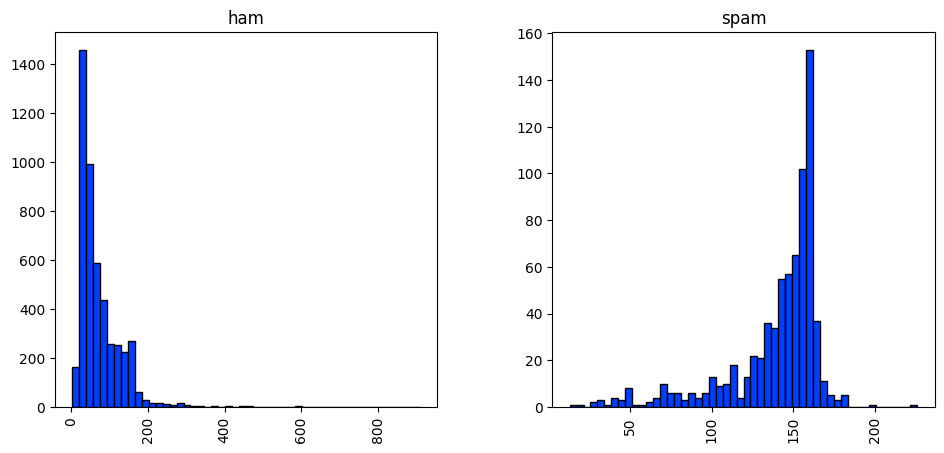

In [40]:
sms['length'] = sms['message'].apply(len)
sms.head()
mpl.rcParams['patch.force_edgecolor'] = True
plt.style.use('seaborn-bright')
sms.hist(column='length', by='label', bins=50,figsize=(11,5))

Как показано по графику, если сообщение длинное, скорее всего это спам.

Определим нашу функцию точности текса. Он также удалит все знаки препинания и стоп-слова.

In [57]:
text_feat = sms['message'].copy()
def text_process(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]

    return " ".join(text)

vectorizer = TfidfVectorizer()
features = vectorizer.fit_transform(text_feat)
features_train, features_test, labels_train, labels_test = train_test_split(features, sms['label'], test_size=0.3, random_state=111)

Разделим набор на обучающую и тестовую выборку и импортируем несколько классификаторов, инициализируем их и создадим словарь для перебора.

In [59]:

features_train, features_test, labels_train, labels_test = train_test_split(features, sms['label'], test_size=0.3, random_state=111)

svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=111)
abc = AdaBoostClassifier(n_estimators=62, random_state=111)
bc = BaggingClassifier(n_estimators=9, random_state=111)
etc = ExtraTreesClassifier(n_estimators=9, random_state=111)

clfs = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc, 'AdaBoost': abc, 'BgC': bc, 'ETC': etc}

def train_classifier(clf, feature_train, labels_train):
    clf.fit(feature_train, labels_train)
def predict_labels(clf, features):
    return (clf.predict(features))


Теперь перебираем классификаторы и выведем результаты.

In [60]:

pred_scores = []
pred_dict={}
for k,v in clfs.items():
    train_classifier(v, features_train, labels_train)
    pred = predict_labels(v,features_test)
    pred_scores.append((k, [accuracy_score(labels_test,pred)]))
    pred_dict[k]=[accuracy_score(labels_test,pred)]

df = pd.DataFrame.from_dict(pred_dict,orient='index', columns=['Score'])
df

,Score
SVC,0.985048
KN,0.944976
NB,0.989833
DT,0.969498
LR,0.959330
RF,0.976675
AdaBoost,0.980861
BgC,0.974282
ETC,0.977871


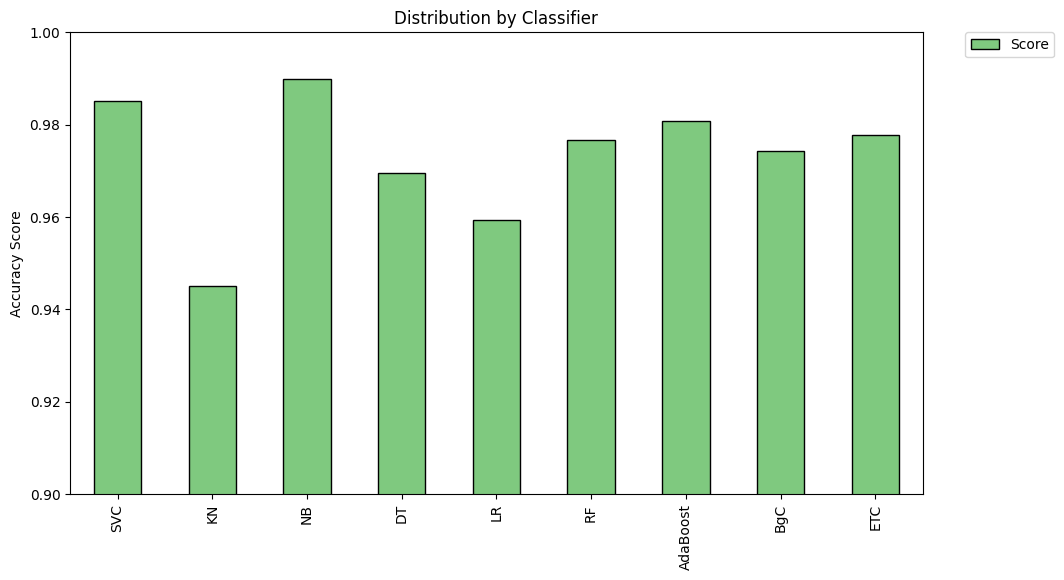

In [61]:
df.plot(kind='bar', ylim=(0.9,1.0), figsize=(11,6), align='center', colormap="Accent")
plt.xticks(np.arange(9), df.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

**Задание 5. Определение спама при помощи моделей глубокого обучения**

Импортируем библиотеки

In [62]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

Прочитаем набор

In [65]:
data = pd.read_csv("/content/sample_data/SPAM text message 20170820 - Data.csv")
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Поменяем спам и обычные сообщения на 1 и 0 соответственно.

In [66]:
data["Category"] = [1 if each == "spam" else 0 for each in data["Category"]]
data.head()

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [67]:
import re
nlp_data = str(data.iloc[2,:])
nlp_data = re.sub("[^a-zA-Z]"," ",nlp_data)

nlp_data = nlp_data.lower()

In [68]:
import nltk as nlp
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nlp_data = nlp.word_tokenize(nlp_data)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Найдём слова "root"

In [69]:
lemma = nlp.WordNetLemmatizer()
nlp_data = [lemma.lemmatize(word) for word in nlp_data]

In [70]:
nlp_data = " ".join(nlp_data)

In [74]:
import nltk as nlp
import re
description_list = []
for description in data["Message"]:
    description = re.sub("[^a-zA-Z]"," ",description)
    description = description.lower()
    description = nlp.word_tokenize(description)
    lemma = nlp.WordNetLemmatizer()
    description = [ lemma.lemmatize(word) for word in description]
    description = " ".join(description)
    description_list.append(description)

In [75]:
from sklearn.feature_extraction.text import CountVectorizer

max_features = 3000  # Максимальное количество признаков (слов)

count_vectorizer = CountVectorizer(max_features=max_features, stop_words="english")
sparse_matrix = count_vectorizer.fit_transform(description_list).toarray()

print("The most common {} words: {}".format(max_features, count_vectorizer.get_feature_names_out()))

The most common 3000 words: ['aah' 'aathi' 'abi' ... 'zed' 'zindgi' 'zoe']


Сделаем выборки

In [77]:

y = data.iloc[:,0].values
x = sparse_matrix
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.1, random_state = 42)

Рассчитаем преблизительную точность

In [78]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(x_train,y_train)
print("the accuracy of our model: {}".format(nb.score(x_test,y_test)))

the accuracy of our model: 0.8763440860215054


Рассчитаем фактическую точность

In [79]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter = 200)
lr.fit(x_train,y_train)
print("our accuracy is: {}".format(lr.score(x_test,y_test)))

our accuracy is: 0.974910394265233


Обучим модель

In [80]:
from sklearn.neighbors import KNeighborsClassifier

# Инициализация классификатора k-ближайших соседей
knn = KNeighborsClassifier(n_neighbors=3)

# Преобразование данных к нужной форме
x_test = x_test.reshape(558, 3000)
x_train = x_train.reshape(5014, 3000)

# Обучение модели
knn.fit(x_train, y_train)

# Оценка точности модели на тестовом наборе данных
accuracy = knn.score(x_test, y_test)
print('With KNN (K=3) accuracy is: ', accuracy)

With KNN (K=3) accuracy is:  0.9408602150537635
